# Analysis

In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(10,7)})
plt.style.use('seaborn-whitegrid')

In [295]:
year = '11'

### Systematic errors?

просто флаг, чтоб отдельно сохранять результат

In [296]:
sys_err = True

## Data preparation


Пример с `open`
```python
f = uproot.open("../outputs/19/trees/550.00_70260.root")
f['t'].pandas.df()
```

In [297]:
f = uproot.pandas.iterate("../outputs/"+year+"/trees/*.root", "t", reportpath = True,
                          branches=['beam_energy', 'mass', 'trigger', 'procedure'])

In [298]:
dataRAW = pd.concat([j.assign(name=float(re.findall(r"\d+\.\d+", path)[0])) for path,j in f])

In [299]:
dataRAW.shape

(4386, 5)

In [300]:
dataRAW.sort_values(by='name', ascending=True, inplace=True);

Количество уникальных `name` в `data` должно совпадать с количеством точек в сезоне

* 11 год: 40 точек
* 12 год: 16 точек
* 17 год: 34 точки
* 19 год: 44 точки
* моделирование: 38 точек

In [301]:
print("Checking:", len(dataRAW.name.unique()), 'different names in', year, 'season')

Checking: 40 different names in 11 season


Проверка типов полей датафрейма

In [302]:
dataRAW.dtypes

beam_energy    float64
mass           float64
trigger          int32
procedure        int32
name           float64
dtype: object

Проверка данных

In [303]:
dataRAW.describe()

,beam_energy,mass,trigger,procedure,name
count,4386.000000,4386.000000,4386.000000,4386.0,4386.000000
mean,609.991556,471.537126,0.863885,2.0,611.063041
std,114.674315,107.775536,0.916557,0.0,115.005342
min,523.580017,1.590631,-1.000000,2.0,525.000000
25%,537.409973,492.431770,0.000000,2.0,537.500000
50%,562.133972,496.916153,1.000000,2.0,562.500000
75%,636.390015,500.977554,2.000000,2.0,637.500000
max,1002.309998,577.198242,2.000000,2.0,1000.000000


Проверить триггер

In [304]:
bad_trig = dataRAW.query('trigger<0')
print('Energy points with bad trigger:\n', bad_trig.name.value_counts())

Energy points with bad trigger:
 525.0    18
Name: name, dtype: int64


Проверить энергии

In [305]:
bad_en = dataRAW.query('beam_energy<0')
print('Bad energy records:', bad_en.name.shape[0])

Bad energy records: 0


Удалить события с плохим триггером и энергиями (не в моделировании)

In [306]:
data = dataRAW if 'model' in year else dataRAW.query('trigger>-1&beam_energy>0')

Оставить только массы внутри окна (450,550) и без процедуры kinfit

In [307]:
data = data.query('mass>450&mass<550&procedure!=1')

In [308]:
print(data.shape[0], 'records left')

4045 records left


Удалить ненужные столбцы

In [309]:
data.drop(['procedure'], axis=1, inplace=True)

In [310]:
data.head()

,beam_energy,mass,trigger,name
666,523.580017,502.045563,1,525.0
581,523.580017,497.077087,0,525.0
582,523.580017,491.056458,1,525.0
583,523.580017,504.232819,1,525.0
584,523.580017,498.035065,1,525.0


Добавить светимости

In [311]:
lum = pd.read_csv(f'../inputs/{year}/lum.dat')
lum.rename({'label': 'name'}, axis=1, inplace=True)
if 'err' in lum.columns:
    lum.drop(['err'], axis=1, inplace=True) #ошибка светимостей уходит в систематику
    
lum = lum.sort_values(by='name').drop_duplicates(subset=['name'])

In [312]:
lum.tail()

,name,lum
17,950.0,498.580
18,962.5,590.841
19,975.0,451.026
20,987.5,506.605
21,1000.0,478.093


Проверить данные (хорошо, если числа совпадают)

Если не совпадают, то проверить светимости на дубликаты

In [313]:
print('Records in  lum:', lum.shape[0])
print('Records in data:', data.name.unique().shape[0])

Records in  lum: 40
Records in data: 40


Объединить данные и светимость

In [314]:
data_prep = lum.merge(data, on='name')

In [315]:
def check_foo(data1, data2):
    if(data1.shape[0] == data2.shape[0]):
        print("Good.", data1.shape[0], 'rows' )
    else:
        print("WARNING. frames haven't equal shape |", data1.shape[0], 'vs', data2.shape[0], 'records')
    return

In [316]:
check_foo(data_prep, data)

Good. 4045 rows


Смотрим, в каких именно точках не совпадают `data` и `lum`

In [317]:
set1 = set(data.name.unique())
set2 = set(lum.name.unique())

(set1|set2).difference(set1&set2)

set()

### Pictures

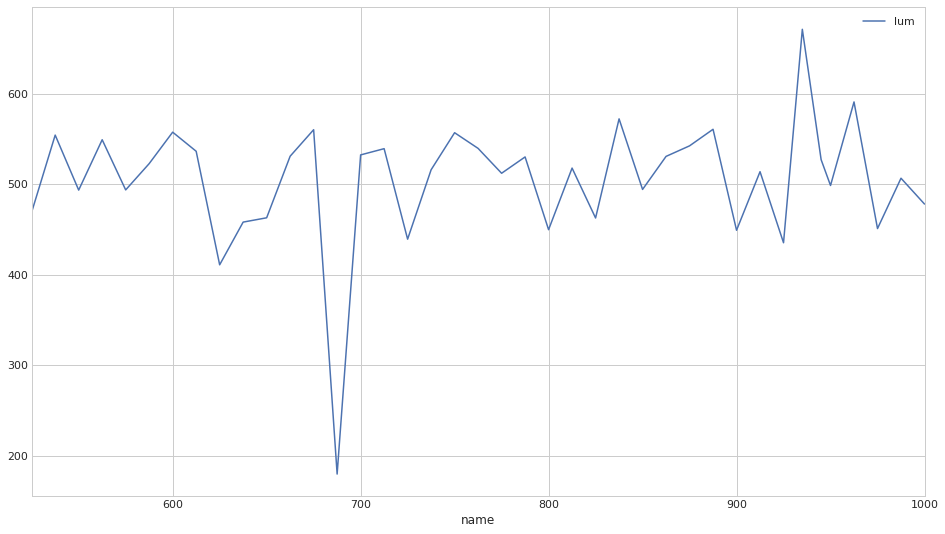

In [318]:
lum.plot(x='name', y='lum')

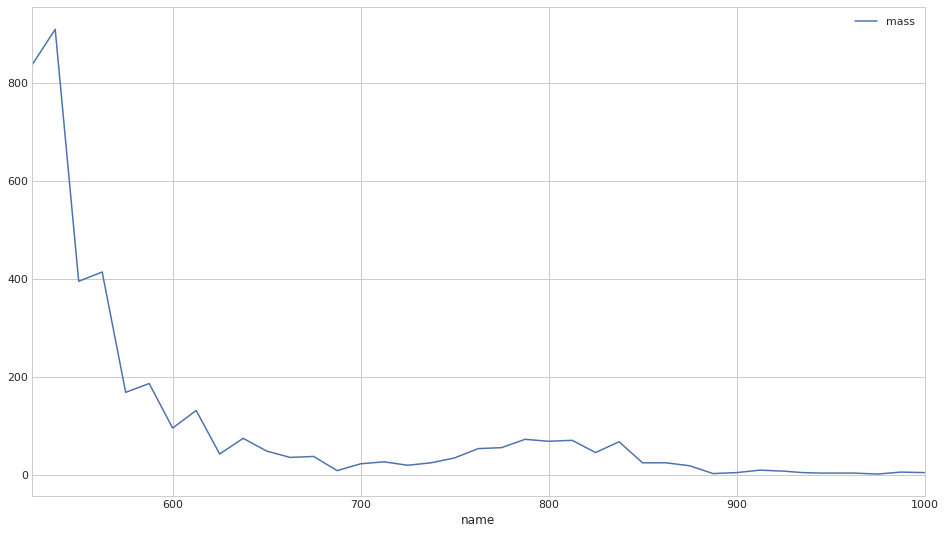

In [319]:
data_prep.groupby('name').agg({'mass':np.size}).plot()

In [320]:
data_prep.groupby('name').agg({'mass':np.size})

,mass
name,
525.0,836.0
537.5,910.0
550.0,395.0
562.5,414.0
575.0,168.0
587.5,186.0
600.0,95.0
612.5,131.0
625.0,42.0


Слияние точек

In [321]:
cnct = []
if year=='11':
    cnct = [([887.5, 900., 912.5, 925., 935.], 910), ([945., 950., 962.5, 975., 987.5, 1000.], 950)] #11year
if year=='12':
    cnct = [([900., 920., 936.], 920), ([950., 960., 970.,], 950), ([ 980., 990], 960)] #12 year
if year=='17':
    cnct = [([880., 890.], 885), ([900., 910.], 905), ([920., 930.], 925),
           ([937.4, 937.5, 938.3, 938.9, 939.6, 940.2, 940.8], 939)] #17 year
#     cnct = [([880., 890., 900., 910.], 900), ([920., 930., 936., 937.5], 935),
#             ([937.4, 938.3, 938.9], 938), ([939.6, 940.2, 940.8], 940),
#             ([942., 950., 960., 971.], 960), ([981., 990, 1003.5],990)] #17 year
# if year=='19': #в последний раз не сливал точки
#     cnct = [([862.5, 875.0, 887.5, 900.0, 912.5, 925], 875),([936, 945.0, 950.0, 951.1, 955.0, 962.5], 955),
#             ([975., 978.0, 987.5], 980)] #19year

In [322]:
for c in cnct:
    data_prep.name.replace(c[0], c[1], inplace=True)

OK, points have been merged

In [323]:
data_prep.tail()

,name,lum,beam_energy,mass,trigger
4040,950.0,506.605,989.221008,527.203430,2
4041,950.0,478.093,1002.309998,498.673920,0
4042,950.0,478.093,1002.309998,494.471771,0
4043,950.0,478.093,1002.309998,481.866150,0
4044,950.0,478.093,1002.309998,496.517883,0


In [324]:
check_foo(data_prep, data)

Good. 4045 rows


### Пересчитать светимости в слитых точках

In [325]:
data_prep['lume'] = data_prep.beam_energy*data_prep.lum

Проверить правильность слияния

In [326]:
#число в поле lum с количеством элементов в списке для слияния
data_prep[['lum', 'name']].\
drop_duplicates(subset=['name','lum']).groupby('name').agg({'lum':np.size}).query('lum!=1')

,lum
name,
910.0,5.0
950.0,6.0


In [327]:
new_lum = data_prep[['beam_energy', 'lum', 'lume', 'name']].drop_duplicates(subset=['lum','name']).\
groupby('name').agg({'lume':[np.sum], 'lum':[np.sum], 'beam_energy':[np.min, np.max]})

In [328]:
new_lum.shape

(31, 4)

In [329]:
new_lum['Emean'] = np.round( new_lum[('lume','sum')]/new_lum[('lum','sum')], 2)

In [330]:
new_lum.columns = ['lume', 'lum', 'dEmin', 'dEmax', 'Emean']
new_lum.drop('lume', axis=1, inplace=True)
new_lum['dEmax'] = np.abs( np.round( new_lum.dEmax-new_lum.Emean, 2) )
new_lum['dEmin'] = np.abs( np.round( new_lum.Emean - new_lum.dEmin, 2) )

In [331]:
#data.loc[641.].beam_energy.std()

In [332]:
new_lum.query('dEmin>0')

,lum,dEmin,dEmax,Emean
name,,,,
910.0,2630.015,25.42,23.31,912.28
950.0,3052.256,24.05,31.56,970.75


I have got new luminosity table.

Now I should join it to existing table

In [333]:
data_prep.drop(['lume', 'lum', 'beam_energy'], axis=1, inplace=True)

In [334]:
final_data = data_prep.join(new_lum, how='inner', on='name')

In [335]:
check_foo(final_data, data_prep)

Good. 4045 rows


That is good. Now I should do the analysis

In [336]:
final_data.tail()

,name,mass,trigger,lum,dEmin,dEmax,Emean
4040,950.0,527.203430,2,3052.256,24.05,31.56,970.75
4041,950.0,498.673920,0,3052.256,24.05,31.56,970.75
4042,950.0,494.471771,0,3052.256,24.05,31.56,970.75
4043,950.0,481.866150,0,3052.256,24.05,31.56,970.75
4044,950.0,496.517883,0,3052.256,24.05,31.56,970.75


----------------
## Fit

In [337]:
data2 = final_data.groupby('name')

In [338]:
dic = {}
for i in data2.groups:
    print(i)
    dic[i] = np.array( data2.get_group(i)['mass'] )

525.0
537.5
550.0
562.5
575.0
587.5
600.0
612.5
625.0
637.5
650.0
662.5
675.0
687.5
700.0
712.5
725.0
737.5
750.0
762.5
775.0
787.5
800.0
812.5
825.0
837.5
850.0
862.5
875.0
910.0
950.0


In [339]:
import iminuit
import probfit as pf

In [340]:
plt.rcParams.update({'font.size': 18, 'figure.figsize':(16,9)})

In [341]:
mass_bound = (450, 550)

In [342]:
#2 гаусса
def constant(x):
    return 1
def two_gauss(x, mu, sigma1, sigma2, frac):
    return frac*pf.gaussian(x, mu, sigma1) + (1-frac)*pf.gaussian(x, mu, sigma2)

norm_sig = pf.rename( pf.Normalized( two_gauss, mass_bound ), ['x', 'M', '$\sigma1$', '$\sigma2$', 'f'] )
norm_bkg = pf.Normalized( constant, mass_bound )

ext_sig = pf.Extended(norm_sig, extname='$N_{sig}$')
ext_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')

pdf = pf.AddPdf(ext_sig, ext_bkg)

MLim = (498.1, 5.0)
sigma1Lim = (6.04, .0)
sigma2Lim = (10., 0)
fLim = (1, 0)

# 11: 𝜎1=(4.49, 0.27) , 𝜎2=(10.1, 1.), 𝑓=(0.68, 0.07), M=(497.299, 0.098)
# 12: 𝜎1=(5.26, 0.30) , 𝜎2=(14.42, 3.87), 𝑓=(0.86, 0.06), M=(498.33, 0.27)
# mod_old: 𝜎1=(5.43, 0.10) , 𝜎2=(12.68, 0.25), 𝑓=(0.58, 0.02), M=(497.05, 0.04)
# mod_new: 𝜎1=(5.35, 0.07) , 𝜎2=(12.74, 0.17), 𝑓=(0.57, 0.02), M=(498.00, 0.03)
limits = {
    "limit_M": [MLim[0]-MLim[1], MLim[0]+MLim[1]],
    "limit_$\sigma1$": [sigma1Lim[0] - sigma1Lim[1], sigma1Lim[0] + sigma1Lim[1]],
    "limit_$\sigma2$": [sigma2Lim[0] - sigma2Lim[1], sigma2Lim[0] + sigma2Lim[1]],
    "limit_$N_{sig}$": [0, 100000],
    "limit_$N_{bkg}$": [0, 2000],
    "limit_f": [fLim[0]-fLim[1], fLim[0]+fLim[1]]
}
errors = {
    "error_M": 1,
    "error_$\sigma1$": 0.1,
    "error_$\sigma2$": 0.,
    "error_$N_{sig}$": 0.3,
    "error_$N_{bkg}$": 0.1,
    "error_f": 0.
}

pf.describe(pdf)

['x', 'M', '$\\sigma1$', '$\\sigma2$', 'f', '$N_{sig}$', '$N_{bkg}$']

In [343]:
def fitter(dic, nbins, energy, binnedLik=False, simple_plot=True):
    
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound) if not(binnedLik) else \
    pf.BinnedLH(pdf, dic, int(nbins*(mass_bound[1]-mass_bound[0])/100.), bound=mass_bound, extended=True)
    
    initial_par_values = {"M": 497.6, "$\sigma1$": 4.26, "$N_{sig}$": np.size(dic),
                          "$\sigma2$": 11.16, "f": 0.5, "$N_{bkg}$": 1}
    mt = iminuit.Minuit(likelihood, **initial_par_values, **errors, **limits, pedantic=False)
    mt.migrad();
        
    if simple_plot:
        likelihood.draw(minuit=mt) if binnedLik else likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)
    else:
        fig = plt.figure(figsize=(16, 10), dpi= 80)
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

        # Define the axes
        ax_main = fig.add_subplot(grid[:-1, :])
        ax_main.grid(ls=':')
        box_1 = {'facecolor':'black', 'boxstyle': 'round'}

        if binnedLik:
            likelihood.draw(minuit=mt, print_par=True);
        else:
            likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound, print_par=True)

        plt.tick_params(labelsize=20);
        plt.xlabel('invariant mass, MeV', fontsize=20)
        plt.ylabel('number of events', fontsize=20)

        # this is an inset axes over the main axes
        ax_bottom = fig.add_subplot(grid[-1, :], xticklabels=[])
        ax_bottom.grid(ls=':')
        likelihood.draw_residual(minuit=mt) if binnedLik else \
        likelihood.draw_residual(minuit=mt, bins=nbins, bound=mass_bound)
    
        plt.savefig(f'../outputs/{year}/figures/fit_e{energy}.pdf')
    return mt, likelihood

In [344]:
itr = iter(dic)

In [345]:
fit_frame = pd.DataFrame(columns=[ 'M', 'S1', 'S2', 'f', 'N', 'C', 
                                  'Merr', 'S1err', 'S2err', 'ferr', 'Nerr', 'Cerr'])

In [346]:
i = next(itr)
print('Label:', i)

Label: 525.0


Migrad quality: True
Real: 836 Found: 836.0054286041557


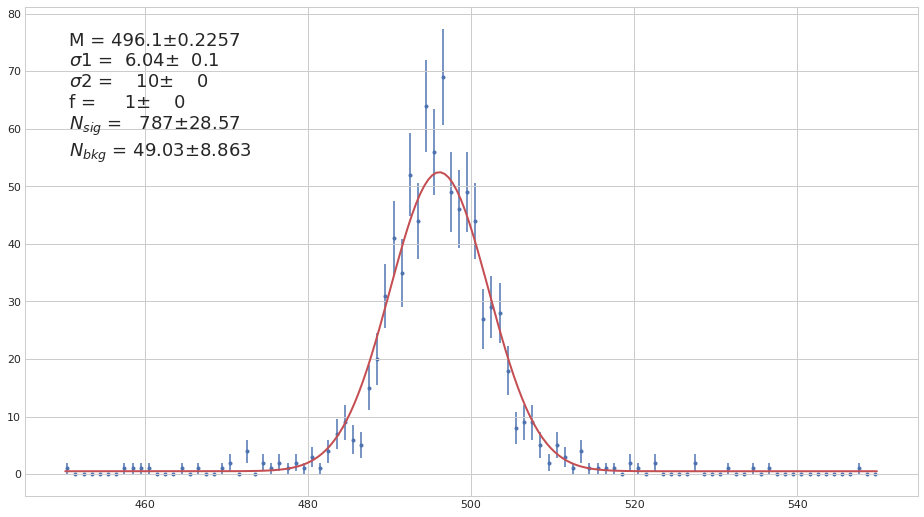

In [347]:
dicx = dic[i]#final_data.mass.values#dic[i]#
# dicx = np.hstack((dic[875],dic[910],dic[950]))
mt, lik = fitter(dicx, 100, i, False, True)
fit_frame.loc[i] = mt.values.values() + mt.errors.values()
print("Migrad quality:", mt.migrad_ok())
print( 'Real:', np.size(dicx), 'Found:', mt.values['$N_{sig}$'] + mt.values['$N_{bkg}$'] )

In [274]:
fit_frame.tail(20)

,M,S1,S2,f,N,C,Merr,S1err,S2err,ferr,Nerr,Cerr
662.5,496.502797,5.070046,10.0,1.0,30.150779,4.842622e+00,1.049064,0.880969,0.0,0.0,5.769197,2.824352
675.0,498.855054,6.837100,10.0,1.0,33.916928,3.084747e+00,1.197280,0.848688,0.0,0.0,5.963990,2.176449
687.5,494.194402,5.530817,10.0,1.0,8.003128,1.499773e-05,1.825268,1.357017,0.0,0.0,2.829253,0.723464
700.0,496.427335,6.570705,10.0,1.0,22.009304,6.983236e-06,1.380516,0.982874,0.0,0.0,4.691897,0.750221
712.5,498.371608,3.120000,10.0,1.0,17.406835,8.591570e+00,0.814112,0.189859,0.0,0.0,4.314992,3.130795
725.0,500.540535,8.375486,10.0,1.0,17.113065,1.888469e+00,2.072845,1.536532,0.0,0.0,4.337617,1.894288
737.5,496.189686,4.504685,10.0,1.0,17.843186,6.144986e+00,1.252980,1.106479,0.0,0.0,4.561804,3.017955
750.0,497.295198,6.363604,10.0,1.0,30.011817,4.011050e+00,1.256347,1.140991,0.0,0.0,5.793014,2.748146
762.5,497.192153,6.292578,10.0,1.0,49.430592,3.572403e+00,0.950087,0.739949,0.0,0.0,7.228767,2.528741
775.0,497.963025,6.999877,10.0,1.0,48.520963,6.479034e+00,1.084347,0.912207,0.0,0.0,7.366914,3.498018


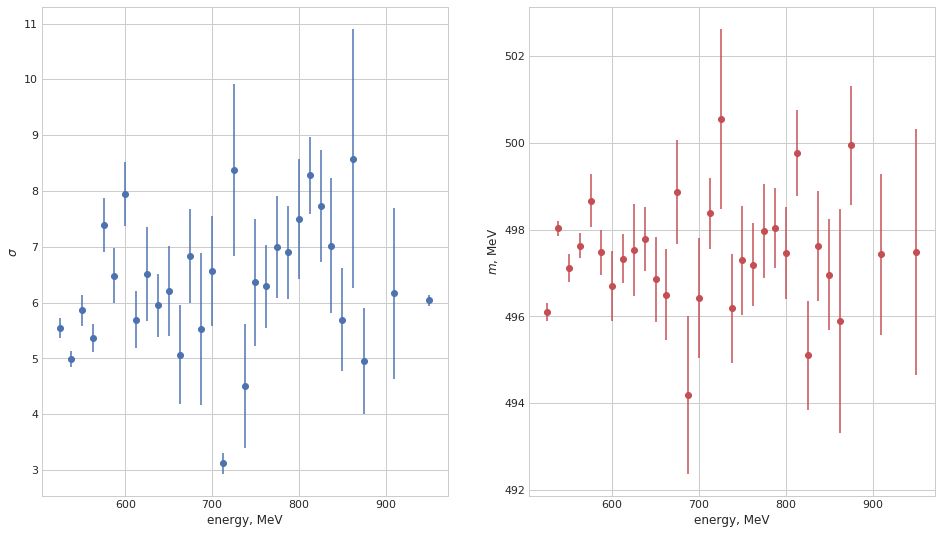

In [273]:
plt.subplot(1, 2, 1)
plt.errorbar(data=fit_frame, x=fit_frame.index, y='S1', yerr='S1err', fmt='o')
plt.xlabel('energy, MeV');
plt.ylabel('$\\sigma$');
plt.subplot(1, 2, 2)

plt.errorbar(x=fit_frame.index, y=fit_frame.M, yerr=fit_frame.Merr, fmt='or')
plt.xlabel('energy, MeV');
plt.ylabel('$m$, MeV');

### Some notes:
none

## Анализ $\sigma$

### 19 год

В точках 550 и 550.1 принципиально различается ширина ( 4.8 vs 6.12 )

В 19 году взял группами точки по энергии и посмотрел их $\sigma$, видно, что ширина растёт вместе с энергией

In [634]:
np.round(fit_frame.S1err.values, 2)

array([0.13, 0.16, 0.16, 0.18, 0.19, 0.25, 0.21, 0.23, 0.26, 0.28, 0.31,
       0.31, 0.31, 0.32, 0.32, 0.3 , 0.31, 0.29, 0.25, 0.25, 0.21, 0.2 ,
       0.21, 0.2 , 0.2 , 0.21, 0.24, 0.27, 0.31, 0.47, 0.44, 0.42, 0.59,
       0.55, 0.56, 0.66, 0.75, 0.25])

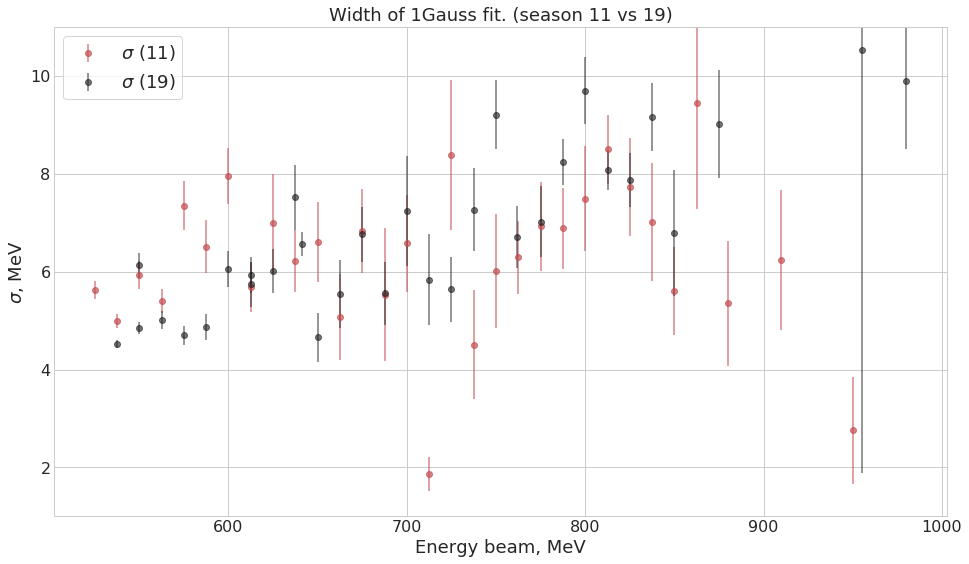

In [651]:
en19_an  = [537.5, 550. , 550.1, 562.5, 575. , 587.5, 600. , 612.5, 612.6,
       625. , 637.5, 641. , 650. , 662.5, 675. , 687.5, 700. , 712.5,
       725. , 737.5, 750. , 762. , 775. , 787.5, 800. , 812.5, 825. ,
       837.5, 850. , 875. , 955. , 980. ]
sigma19_an = [ 4.52,  4.85,  6.13,  5.01,  4.7 ,  4.87,  6.05,  5.74,  5.93,
        6.02,  7.52,  6.57,  4.66,  5.54,  6.76,  5.56,  7.24,  5.83,
        5.64,  7.27,  9.21,  6.71,  7.02,  8.25,  9.7 ,  8.08,  7.87,
        9.16,  6.79,  9.02, 10.53,  9.9 ]
dsigma19_an = [0.09, 0.13, 0.26, 0.18, 0.19, 0.26, 0.37, 0.46, 0.36, 0.45, 0.67,
       0.24, 0.5 , 0.69, 0.56, 0.64, 1.13, 0.93, 0.66, 0.84, 0.71, 0.63,
       0.73, 0.47, 0.69, 0.41, 0.55, 0.7 , 1.28, 1.1 , 8.64, 1.39]

enMC_an = [ 550. ,  562.5,  575. ,  587.5,  600. ,  612.5,  625. ,  637.5,
        650. ,  662.5,  675. ,  687.5,  700. ,  712.5,  725. ,  737.5,
        750. ,  762.5,  775. ,  787.5,  800. ,  812.5,  825. ,  837.5,
        850. ,  862.5,  875. ,  887.5,  900. ,  912.5,  925. ,  935. ,
        945. ,  950. ,  962.5,  975. ,  987.5, 1000. ]
sigmaMC_an = [5.5 , 5.87, 5.98, 6.3 , 6.23, 6.79, 6.33, 7.3 , 7.29, 7.54, 7.32,
       7.12, 7.39, 7.85, 7.59, 7.94, 7.64, 8.14, 7.99, 8.52, 8.4 , 8.44,
       8.51, 8.3 , 8.73, 8.77, 8.87, 8.3 , 8.95, 8.55, 9.21, 8.9 , 9.25,
       8.94, 9.4 , 9.67, 8.87, 8.95]
dsigmaMC_an = [0.12, 0.15, 0.17, 0.17, 0.21, 0.2 , 0.25, 0.29, 0.26, 0.34, 0.27,
       0.24, 0.32, 0.27, 0.33, 0.27, 0.23, 0.24, 0.23, 0.2 , 0.19, 0.18,
       0.15, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.23, 0.28, 0.24, 0.3 ,
       0.26, 0.29, 0.37, 0.36, 0.36]

enMCold_an = [ 550. ,  562.5,  575. ,  587.5,  600. ,  612.5,  625. ,  637.5,
        650. ,  662.5,  675. ,  687.5,  700. ,  712.5,  725. ,  737.5,
        750. ,  762.5,  775. ,  787.5,  800. ,  812.5,  825. ,  837.5,
        850. ,  862.5,  875. ,  887.5,  900. ,  912.5,  925. ,  935. ,
        945. ,  950. ,  962.5,  975. ,  987.5, 1000. ]
sigmaMCold_an = [ 5.85,  6.39,  6.24,  6.99,  6.54,  6.85,  6.17,  7.27,  7.29,
        7.7 ,  7.3 ,  7.76,  7.34,  7.22,  7.45,  7.84,  8.52,  8.05,
        8.02,  8.09,  8.5 ,  8.39,  8.54,  8.37,  9.37,  8.94,  9.12,
        8.72,  8.85,  8.73,  8.95,  9.16,  8.8 ,  9.12, 10.23,  9.56,
        9.83, 10.53]
dsigmaMCold_an = [0.13, 0.16, 0.16, 0.18, 0.19, 0.25, 0.21, 0.23, 0.26, 0.28, 0.31,
       0.31, 0.31, 0.32, 0.32, 0.3 , 0.31, 0.29, 0.25, 0.25, 0.21, 0.2 ,
       0.21, 0.2 , 0.2 , 0.21, 0.24, 0.27, 0.31, 0.47, 0.44, 0.42, 0.59,
       0.55, 0.56, 0.66, 0.75, 0.25]

en11_an = [525. , 537.5, 550. , 562.5, 575. , 587.5, 600. , 612.5, 625. ,
       637.5, 650. , 662.5, 675. , 687.5, 700. , 712.5, 725. , 737.5,
       750. , 762.5, 775. , 787.5, 800. , 812.5, 825. , 837.5, 850. ,
       862.5, 880. , 910. , 950. ]
sigma11_an = [5.63, 4.99, 5.93, 5.4 , 7.35, 6.51, 7.95, 5.69, 6.99, 6.22, 6.6 ,
       5.07, 6.83, 5.53, 6.58, 1.87, 8.38, 4.51, 6.01, 6.29, 6.93, 6.89,
       7.49, 8.5 , 7.73, 7.02, 5.61, 9.45, 5.35, 6.24, 2.76]
dsigma11_an = [0.18, 0.15, 0.28, 0.25, 0.5 , 0.54, 0.57, 0.51, 1.01, 0.63, 0.82,
       0.88, 0.85, 1.36, 0.99, 0.35, 1.53, 1.12, 1.16, 0.74, 0.91, 0.83,
       1.07, 0.7 , 1.01, 1.21, 0.9 , 2.16, 1.27, 1.43, 1.09]

df_sigma_an = pd.DataFrame({'emin':emin_an, 'emax':emax_an, 'sigma':sigma_an, 'ds': dsigma_an})
df_sigma_an['emean'] = (df_sigma_an.emin + df_sigma_an.emax)/2.
df_sigma_an['deup'] = df_sigma_an.emean - df_sigma_an.emin
# plt.errorbar(x=enMC_an, y=sigmaMC_an, yerr=dsigmaMC_an, fmt='o', alpha=0.8, label='$\sigma$ (MC)')
# plt.errorbar(x=enMCold_an, y=sigmaMCold_an, yerr=dsigmaMCold_an, alpha=0.8, fmt='oc', label='$\sigma$ (MC_old)')
plt.errorbar(x=en11_an, y=sigma11_an, yerr=dsigma11_an, fmt='or', alpha=0.7, label='$\sigma$ (11)')
plt.errorbar(x=en19_an, y=sigma19_an, yerr=dsigma19_an, fmt='ok', alpha=0.6, label='$\sigma$ (19)')
plt.legend(fontsize=18, frameon=True);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.ylim(1, 11)
plt.xlabel('Energy beam, MeV', fontsize=18);
plt.ylabel('$\sigma$, MeV', fontsize=18);
plt.title('Width of 1Gauss fit. (season 11 vs 19)', fontsize=18);
plt.savefig('sigma3.pdf')

Возникает гипотеза (ещё и с учётом того факта, что на большой статистике данные описываются не идеально) добавить ещё один гаусс. Посмотрим, что из этого выйдет.

Повторю распределение сигм по аналогии с картинкой выше

<ErrorbarContainer object of 3 artists>

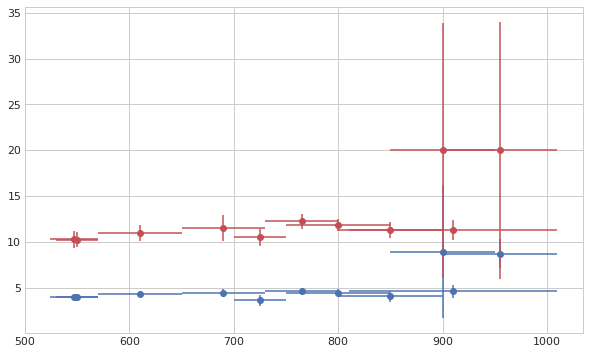

In [552]:
plt.rcParams.update({'font.size': 18, 'figure.figsize':(10,6)})
emin_an  = [524, 570, 650, 730, 800, 900, 850, 750, 700, 530, 810]
emax_an  = [570, 650, 730, 800, 900, 1010, 950, 850, 750, 570, 1010]
sigma1_an = [4.02, 4.31, 4.44, 4.66, 4.08, 8.724847949065675, 8.952093654550044, 4.509152675111134, 3.6841658856535178, 4.01709961911671, 4.628942053127934]
dsigma1_an = [0.13, 0.18, 0.44, 0.39, 0.55, 1.590062670581002, 7.270944904440277, 0.3453623743108212, 0.6048651400716212, 0.1190920659859942, 0.7016815273028718]
sigma2_an = [10.3, 10.98, 11.55, 12.25, 11.34, 19.995900427431625, 19.999882612152, 11.866375420268561, 10.53279261428423, 10.283255759137344, 11.339313291171166]
dsigma2_an = [0.9, 0.85, 1.42, 0.81, 0.89, 13.996992016425061, 13.933962567163773, 0.6617076556061905, 0.9474962757272731, 0.8289418695468278, 1.1023824322696134]
frac12_an = [3.92, 2.31, 1.76, 0.88, 0.64, 2.728843351319719, 6.911293728105318, 0.8379169741736125, 0.7006647553677061, 3.9196405944377877, 0.62839843050261]
df_sigma_an = pd.DataFrame({'emin':emin_an, 'emax':emax_an, 'sigma1':sigma1_an, 'ds1': dsigma1_an, 
                            'sigma2':sigma2_an, 'ds2': dsigma2_an, 'frac': frac12_an})
df_sigma_an['emean'] = (df_sigma_an.emin + df_sigma_an.emax)/2.
df_sigma_an['deup'] = df_sigma_an.emean - df_sigma_an.emin
plt.errorbar(data=df_sigma_an, x='emean', y='sigma1', xerr='deup', yerr='ds1', fmt='ob')
plt.errorbar(data=df_sigma_an, x='emean', y='sigma2', xerr='deup', yerr='ds2', fmt='or')

Видно, что каждая из сигм практически не сдвигается. Но видно, что на малом объёме данных ширины начинают расплываться (заметно при высоких энергиях)

Зафиксирую ширины на средних без учёта выпавших точек

In [238]:
print('Sigma1:', df_sigma_an.drop([5,6]).sigma1.mean() )
print('Sigma2:', df_sigma_an.drop([5,6]).sigma2.mean() )

Sigma1: 4.261040025889923
Sigma2: 11.160193009429035


Тогда проверяю предположение, что $\sigma$ в случае одного гаусса меняется из-за того, что меняется доля событий под узким и широким гауссами меняется с энергией

<ErrorbarContainer object of 3 artists>

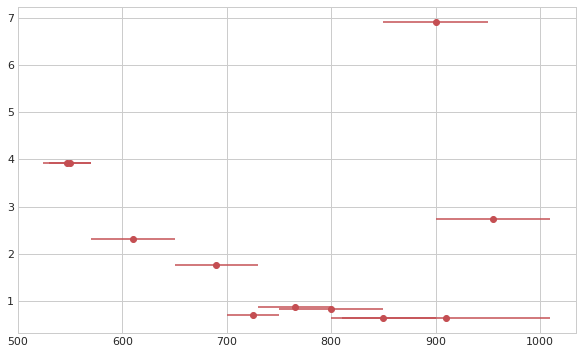

In [314]:
plt.errorbar(data=df_sigma_an, x='emean', y='frac', xerr='deup', fmt='or')

Теперь 2 гаусса для моделирования (`model_new`)

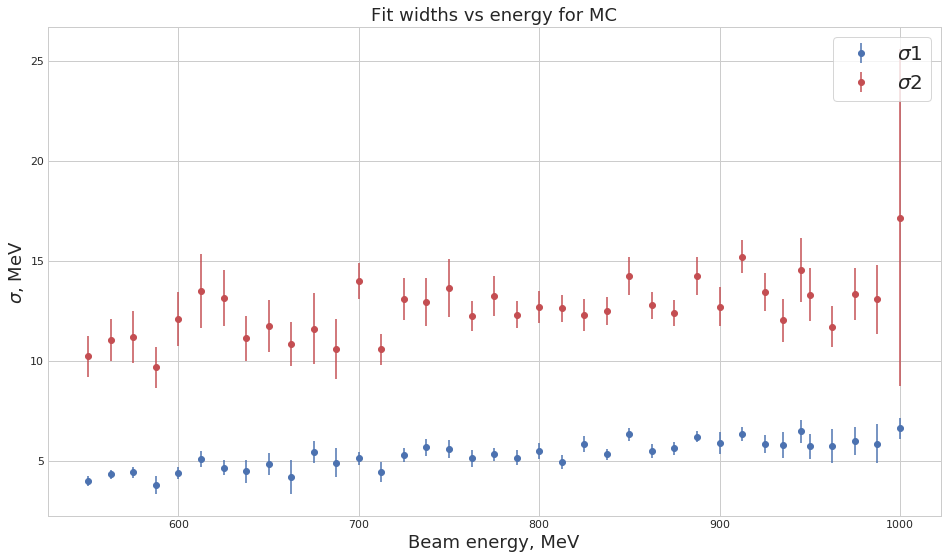

In [194]:
en_an = [ 550. ,  562.5,  575. ,  587.5,  600. ,  612.5,  625. ,  637.5,
        650. ,  662.5,  675. ,  687.5,  700. ,  712.5,  725. ,  737.5,
        750. ,  762.5,  775. ,  787.5,  800. ,  812.5,  825. ,  837.5,
        850. ,  862.5,  875. ,  887.5,  900. ,  912.5,  925. ,  935. ,
        945. ,  950. ,  962.5,  975. ,  987.5, 1000. ]
s1_an = [4.00928888, 4.33747255, 4.43559649, 3.803059  , 4.423181  ,
       5.1014904 , 4.66565474, 4.5045961 , 4.87810257, 4.1960529 ,
       5.43876272, 4.91843674, 5.14132747, 4.45975828, 5.31429813,
       5.69505078, 5.60314509, 5.14196975, 5.3540354 , 5.16952826,
       5.50877517, 4.94773543, 5.86872395, 5.33462472, 6.33305366,
       5.50748813, 5.64094449, 6.22043922, 5.8916277 , 6.35738374,
       5.86313576, 5.82890009, 6.48632741, 5.73844622, 5.75707775,
       6.0104084 , 5.87187928, 6.64138695]
s2_an = [10.24281036, 11.05319352, 11.18820377,  9.68060542, 12.08471558,
       13.48858781, 13.14961493, 11.13335416, 11.74951692, 10.83995468,
       11.62019776, 10.61195066, 13.99189698, 10.58376123, 13.09259816,
       12.95582443, 13.64101323, 12.22498239, 13.24488383, 12.3034521 ,
       12.69676957, 12.62291336, 12.27461984, 12.50987221, 14.22699406,
       12.77836884, 12.39655738, 14.23327043, 12.70892288, 15.21270754,
       13.44290652, 12.03170836, 14.54893378, 13.31082015, 11.72120822,
       13.3503376 , 13.0830581 , 17.15999921]
s1err_an = [0.24420247, 0.23628817, 0.2793554 , 0.43500637, 0.30562574,
       0.41426316, 0.36829545, 0.57240212, 0.55104936, 0.83858414,
       0.54760894, 0.72628265, 0.32523255, 0.51859386, 0.3644784 ,
       0.43592776, 0.44839775, 0.42269701, 0.32609865, 0.3645667 ,
       0.37670574, 0.36108701, 0.38803313, 0.29671017, 0.31075945,
       0.34238496, 0.33784375, 0.2866558 , 0.54865994, 0.35272085,
       0.43615359, 0.64643721, 0.55803832, 0.61537946, 0.86046785,
       0.71916831, 0.972075  , 0.51998215]
s2err_an = [1.02206463, 1.06032287, 1.28551181, 1.00666387, 1.33649728,
       1.83713476, 1.38658335, 1.13404142, 1.28373445, 1.08777375,
       1.78985585, 1.48944632, 0.89674085, 0.7724873 , 1.03681978,
       1.19733482, 1.46254629, 0.7502984 , 0.97471297, 0.6738531 ,
       0.78451445, 0.65602477, 0.80038106, 0.69198662, 0.94256228,
       0.66889848, 0.66153967, 0.94133285, 0.96653921, 0.84317584,
       0.94040895, 1.08274286, 1.57935263, 1.31951827, 1.03343693,
       1.29964889, 1.72233654, 8.39968307]
plt.errorbar(x=en_an, y=s1_an, yerr=s1err_an, fmt='ob', label='$\sigma1$')
plt.errorbar(x=en_an, y=s2_an, yerr=s2err_an, fmt='or', label='$\sigma2$')
plt.legend(frameon=True, fontsize=20);
plt.xlabel('Beam energy, MeV', fontsize=18);
plt.title('Fit widths vs energy for MC', fontsize=18)
plt.ylabel('$\sigma$, MeV', fontsize=18);
# plt.savefig('4.pdf')

По сигме всё более-менее хорошо, а вот следующее распределение по отношению событий в гауссах смущает.

Возможно это из-за каких-то разногласий моделирования и эксперимента, хотелось бы верить, но неизвестно

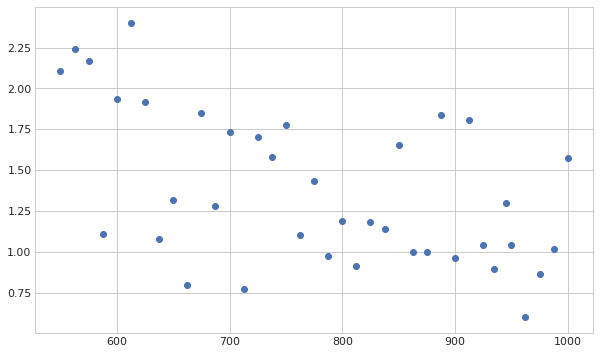

In [554]:
frac_an = [2.1047093 , 2.24281089, 2.16611316, 1.10671026, 1.93781416,
       2.39827954, 1.91504091, 1.07766751, 1.31920011, 0.79416602,
       1.84898383, 1.27802379, 1.73464467, 0.7721512 , 1.70095568,
       1.58280159, 1.77529039, 1.09981627, 1.43251272, 0.97705235,
       1.18825784, 0.9150671 , 1.18416207, 1.14115352, 1.6519543 ,
       0.99945712, 1.00099901, 1.83883042, 0.96433868, 1.8047252 ,
       1.04416522, 0.89545267, 1.29761692, 1.0409458 , 0.60057145,
       0.86444899, 1.01426618, 1.57182104]
plt.scatter(en_an, frac_an)

Смущает распределение по отношению гауссов, поэтому зафиксирую все параметры гауссов из полного распределения:

$\sigma_1 = 4.178 \pm 0.096$ , $\sigma_2 = 11.06 \pm 0.42$, $ f = 0.67 \pm 0.02$

### 17 год

Распределение по всем точкам даёт 
$\sigma_1 = 5.77 \pm 0.56$, $\sigma_2 = 13.44 \pm 2.12$, $f = 0.61 \pm 0.1 $, $M = 498.49 \pm 0.23$

### 11 год

Распределение по всем точкам даёт $\sigma_1 = 4.49 \pm 0.27$ , $\sigma_2 = 10.1 \pm 1.$, $ f = 0.68 \pm 0.07$. 

Я взял данные значения и разрешил им варьироваться в пределах ошибки

### 12 год

$\sigma_1 = 5.26 \pm 0.30$ , $\sigma_2 = 14.42 \pm 3.87$, $ f = 0.86 \pm 0.06$, $ M = 498.33 \pm 0.27$

### Model Old

$\sigma_1 = 5.43 \pm 0.10$ , $\sigma_2 = 12.68 \pm 0.25$, $ f = 0.58 \pm 0.02$, $ M = 497.05 \pm 0.04$

# Save fit info

In [276]:
fit_frame.to_csv(f'../outputs/{year}/tables/fit_frame{"_sys" if sys_err else ""}.csv')

In [277]:
#mt.matrix(correlation=True)
#mt.draw_profile('Nsig');

In [278]:
dataN = fit_frame[['N','Nerr']]
dataN.columns = ['Nsig', 'dNsig']
dataN.index.names = ['name']

In [279]:
dataN.tail()

,Nsig,dNsig
name,,
850.0,21.106354,4.739335
862.5,16.026670,4.834911
875.0,14.083435,3.905737
910.0,16.062441,4.578415
950.0,8.083615,3.500607


I have got table with events numbers

Now, I will get rid of m-field in the data table (because, I have used it)

In [280]:
data_info = final_data.drop_duplicates(['name','lum']).drop(['mass', 'trigger'], axis=1).set_index('name')

In [281]:
dataN = data_info.join(dataN, how='inner')
dataN

,lum,dEmin,dEmax,Emean,Nsig,dNsig
name,,,,,,
525.0,469.339,0.00,0.00,523.58,779.105080,28.675135
537.5,554.231,0.00,0.00,537.41,877.979011,30.091091
550.0,493.501,0.00,0.00,548.44,376.083144,19.864805
562.5,549.094,0.00,0.00,562.13,384.663283,20.203923
575.0,493.710,0.00,0.00,575.31,158.841076,12.960894
587.5,522.721,0.00,0.00,587.05,174.852337,13.805930
600.0,557.452,0.00,0.00,598.04,95.015190,9.747947
612.5,536.375,0.00,0.00,611.71,119.410919,11.374638
625.0,411.009,0.00,0.00,622.47,40.651600,6.451678


In [282]:
check_foo(dataN, fit_frame)

Good. 31 rows


OK, save it

In [283]:
dataN.to_csv(f'../outputs/{year}/tables/signal_table{year}{"_sys" if sys_err else ""}.csv', float_format='%.4f')

Ok, now about triggers

In [348]:
triggers = final_data[['trigger','name']].set_index('name')
triggers = triggers.assign(one = 1);

In [349]:
triggers

,trigger,one
name,,
525.0,1,1
525.0,0,1
525.0,1,1
525.0,1,1
525.0,1,1
...,...,...
950.0,2,1
950.0,0,1
950.0,0,1


In [350]:
check_foo(triggers, final_data)

Good. 4045 rows


In [287]:
triggers = pd.pivot_table(triggers, values='one', columns=['trigger'], index='name', aggfunc=np.sum).fillna(0)

In [288]:
triggers.columns = ['TF', 'CF', 'TC']

In [289]:
triggers.head()

,TF,CF,TC
name,,,
525.0,309.0,375.0,152.0
537.5,503.0,18.0,389.0
550.0,230.0,62.0,103.0
562.5,235.0,9.0,170.0
575.0,96.0,27.0,45.0


In [290]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

In [291]:
triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                              np.square((1-triggers['eCF'])*triggers['vTF']) )

OK, trigers have been got

In [292]:
check_foo(triggers, dataN)

Good. 31 rows


In [293]:
triggers.to_csv(f'../outputs/{year}/tables/triggers{year}{"_sys" if sys_err else ""}.csv', float_format='%.4f')

In [294]:
triggers

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
name,,,,,,,,,
525.0,309.0,375.0,152.0,0.289225,0.330454,0.524103,0.019695,0.021837,0.020366
537.5,503.0,18.0,389.0,0.953545,0.436242,0.973811,0.010394,0.016577,0.005910
550.0,230.0,62.0,103.0,0.622754,0.310448,0.739870,0.037395,0.025241,0.027488
562.5,235.0,9.0,170.0,0.944751,0.420147,0.967964,0.016935,0.024436,0.009912
575.0,96.0,27.0,45.0,0.621622,0.321678,0.743338,0.056001,0.038927,0.040742
587.5,106.0,4.0,76.0,0.939024,0.418478,0.964541,0.026265,0.036269,0.015433
600.0,44.0,24.0,27.0,0.528302,0.383562,0.709227,0.067932,0.056526,0.049644
612.5,75.0,4.0,52.0,0.913793,0.410853,0.949211,0.036540,0.043150,0.021846
625.0,26.0,3.0,13.0,0.777778,0.341463,0.853659,0.095377,0.073171,0.064880


### Check triggers

In [335]:
trig_data = pd.read_csv('../outputs/11/tables/triggers11.csv')

In [336]:
trig_data

,name,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
0,525.0,319.0,384.0,154.0,0.2870,0.3263,0.5197,0.0194,0.0215,0.0202
1,537.5,510.0,20.0,393.0,0.9494,0.4354,0.9714,0.0107,0.0165,0.0061
2,550.0,235.0,62.0,103.0,0.6228,0.3059,0.7381,0.0374,0.0250,0.0276
3,562.5,237.0,9.0,170.0,0.9448,0.4181,0.9679,0.0169,0.0244,0.0099
4,575.0,97.0,27.0,45.0,0.6216,0.3194,0.7425,0.0560,0.0387,0.0408
5,587.5,107.0,4.0,76.0,0.9390,0.4162,0.9644,0.0263,0.0361,0.0155
6,600.0,45.0,25.0,27.0,0.5185,0.3784,0.7007,0.0674,0.0560,0.0498
7,612.5,75.0,4.0,52.0,0.9138,0.4109,0.9492,0.0365,0.0432,0.0218
8,625.0,27.0,3.0,13.0,0.7778,0.3333,0.8519,0.0954,0.0719,0.0656
9,637.5,49.0,0.0,27.0,0.9655,0.3590,0.9779,0.0333,0.0540,0.0214
